Torch is already installed in Colab - but you can run for fun to check

In [ ]:
#!pip3 install torch

Add the DLH folder in the top-level of your Google Drive
Mount Colab to this location (only run once)

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
os.chdir("drive/My Drive/DLH_Project")

Mounted at /content/drive


In [ ]:
%pwd

'/content/drive/.shortcut-targets-by-id/1vmmLQvXIsZR9fm3bw0w0w0S4STu7QfhY/DLH_Project'

Check that we are in the DLH_Project folder

Load the necessary modules


In [ ]:
import pandas as pd
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from skimage import io, transform
import numpy as np

In [ ]:
IMG_PATH =  '/content/drive/MyDrive/DLH_Project/images/'
TRAIN_CSV = '/content/drive/My Drive/DLH_Project/images/MultiLabelTrain.csv'  #input your train.csv file here
VALID_CSV = '/content/drive/MyDrive/DLH_Project/images/MultiLabelTest.csv'   #input your valid.csv file here


Create custom dataset for loading images from the filepaths specified in the CSV

In [ ]:
df_train = pd.read_csv(TRAIN_CSV, header=None)
df_test = pd.read_csv(VALID_CSV, header=None)

In [ ]:
df_train.shape

(2473, 19)

In [ ]:
df_test.shape

(314, 19)

In [ ]:
from torch.utils.data import Dataset 

class PneumoniaDataset(Dataset): 
  def __init__(self, csv_file, root_dir, transform = None): 
    df0 = pd.read_csv(csv_file, header=None) 
    df = self.dfFilter(df0, n=MAXSAMPLES)  #change MAXSAMPLES if you don't want to use entire dataset
    #print(df.head(5))
    self.data_file = df
    self.root_dir = root_dir  #not being used since full path is given in my code
    self.transform = transform

  #this is new code added to filter the df, modify for your needs
  def dfFilter(self, df, n):  
    #df = df.iloc[0:n,:]                   #include up to n records

    df.fillna(0, inplace=True)            #change all nan to 0
    #df = df[df.iloc[:, 3] == 'Frontal']  #filter views: Frontal or Lateral
    df_col3 = df.iloc[:,3]
    df_f = df[df_col3 == 'Frontal']
    for i in range(5,19):                 #5,19 denotes labels 1-14
      for j in range(len(df_f)):            #convert all -1s to 0s
        if df_f.iloc[j,i] < 0:
          df_f.iloc[j,i] = 0
    print('n samples = ', len(df_f))        #print descriptive info on data...
    for k in range(5,19):
      print(df_f.columns[k], '\t\t', df_f.iloc[:,k].sum(), 'positive labels')
    return df_f

  def __len__(self):
    return(len(self.data_file))

  def __getitem__(self, idx): 
    path = self.data_file
    #img_path = os.path.join(self.root_dir, self.data_file.iloc[idx, 0])
    img_path = IMG_PATH + self.data_file.iloc[idx, 0]
    #print(img_path)
    image = io.imread(img_path)
    if self.transform:
      image = self.transform(image)
    y = self.data_file.iloc[idx, 5:19]  #important!!! change y for multilabel classification
    y = np.array(y, dtype='float')
    y = torch.tensor(y, dtype = torch.float32)  #dont forget to change y to tensor; long is required for loss calculation see https://jdhao.github.io/2017/11/15/pytorch-datatype-note/
    return image, y

Build x-ray dataset
Look at the dataset

Note: We will want to truncate the CSV to only the images we have loaded

In [ ]:
'''
dataset = PneumoniaDataset(csv_file=TRAIN_CSV, root_dir="images/", transform=transforms.ToTensor())  #root_dir not being used since full path is given in TRAIN_CSV
# using the ToTensor transform to grab image shape easily

print(len(dataset))
for i in range(1):
  print(i, dataset[i])
  print(i, "image shape: ", dataset[i][0].size())
'''  

'\ndataset = PneumoniaDataset(csv_file=TRAIN_CSV, root_dir="images/", transform=transforms.ToTensor())  #root_dir not being used since full path is given in TRAIN_CSV\n# using the ToTensor transform to grab image shape easily\n\nprint(len(dataset))\nfor i in range(1):\n  print(i, dataset[i])\n  print(i, "image shape: ", dataset[i][0].size())\n'

Dataloader


In [ ]:
def load_data(csv_filepath, root_dir):
  img_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.RandomResizedCrop(224)
  ])
  train_data = PneumoniaDataset(csv_filepath, root_dir, transform = img_transform) 
  train_loader = torch.utils.data.DataLoader(train_data, batch_size = 32, shuffle = True) 
  return train_loader

In [ ]:
train_loader = load_data(TRAIN_CSV, root_dir="images/")  #root_dir not being used since full path is given in TRAIN_CSV

n samples =  2473
5 		 256.0 positive labels
6 		 108.0 positive labels
7 		 308.0 positive labels
8 		 1136.0 positive labels
9 		 97.0 positive labels
10 		 570.0 positive labels
11 		 153.0 positive labels
12 		 56.0 positive labels
13 		 352.0 positive labels
14 		 259.0 positive labels
15 		 970.0 positive labels
16 		 39.0 positive labels
17 		 98.0 positive labels
18 		 1318.0 positive labels


In [ ]:
#sanity checks

data = iter(train_loader)
data_batch1 = next(data)
print(data_batch1[0].shape)  #shape looks right
print(data_batch1[0][0])  #data of 1st sample (1,224,224)


torch.Size([32, 1, 224, 224])
tensor([[[0.0379, 0.0379, 0.0325,  ..., 0.3123, 0.3390, 0.3256],
         [0.0314, 0.0297, 0.0275,  ..., 0.3143, 0.3176, 0.3178],
         [0.0314, 0.0307, 0.0306,  ..., 0.3183, 0.3254, 0.3315],
         ...,
         [0.9349, 0.9240, 0.9517,  ..., 0.1361, 0.1375, 0.1508],
         [0.9317, 0.9182, 0.9463,  ..., 0.1339, 0.1421, 0.1416],
         [0.9094, 0.9383, 0.9455,  ..., 0.1375, 0.1443, 0.1366]]])


In [ ]:
#data_batch1[1]

In [ ]:
valid_loader = load_data(VALID_CSV, root_dir="images/")  #root_dir not being used since full path is given in VALID_CSV

n samples =  314
5 		 30.0 positive labels
6 		 22.0 positive labels
7 		 49.0 positive labels
8 		 152.0 positive labels
9 		 13.0 positive labels
10 		 79.0 positive labels
11 		 25.0 positive labels
12 		 9.0 positive labels
13 		 40.0 positive labels
14 		 18.0 positive labels
15 		 113.0 positive labels
16 		 5.0 positive labels
17 		 21.0 positive labels
18 		 187.0 positive labels


In [ ]:
#sanity checks
data = iter(valid_loader)
data_batch1 = next(data)
print(data_batch1[0].shape)  #shape looks right
print(data_batch1[0][0])  #data of 1st sample (1,224,224)


torch.Size([32, 1, 224, 224])
tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0610, 0.0546, 0.0595],
         [0.0021, 0.0039, 0.0031,  ..., 0.0666, 0.0592, 0.0622],
         [0.0034, 0.0039, 0.0050,  ..., 0.0578, 0.0607, 0.0777],
         ...,
         [0.6184, 0.6006, 0.6348,  ..., 0.8061, 0.8022, 0.7662],
         [0.6523, 0.6175, 0.6302,  ..., 0.8005, 0.7972, 0.7637],
         [0.6333, 0.6100, 0.6201,  ..., 0.8168, 0.8134, 0.7690]]])


Example images


n samples =  2473
5 		 256.0 positive labels
6 		 108.0 positive labels
7 		 308.0 positive labels
8 		 1136.0 positive labels
9 		 97.0 positive labels
10 		 570.0 positive labels
11 		 153.0 positive labels
12 		 56.0 positive labels
13 		 352.0 positive labels
14 		 259.0 positive labels
15 		 970.0 positive labels
16 		 39.0 positive labels
17 		 98.0 positive labels
18 		 1318.0 positive labels


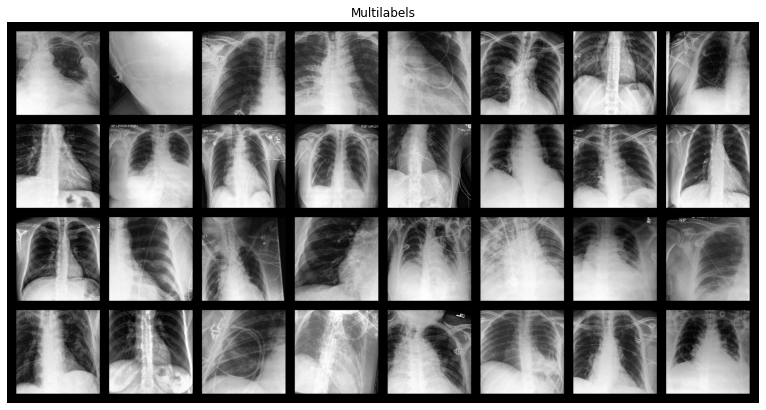

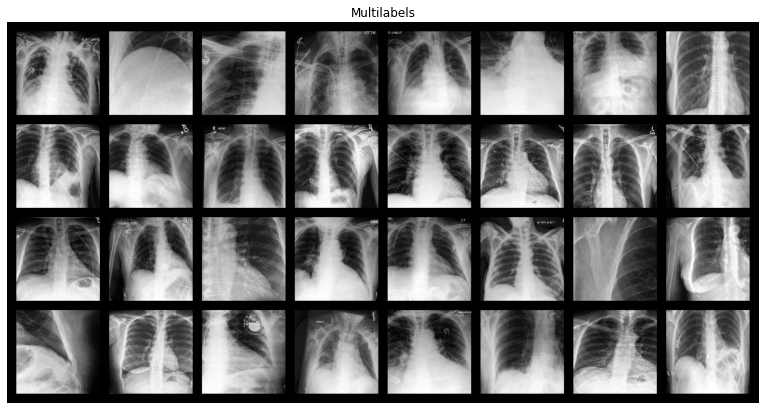

In [ ]:
import numpy as np

def imshow(img, title):
    npimg = img.numpy()
    plt.figure(figsize=(15, 7))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images, padding=25)
    #imshow(img, title=["NORMAL" if x==0  else "PNEUMONIA" for x in labels])  #for single label only
    imshow(img, title='Multilabels')
train_loader = load_data(TRAIN_CSV, root_dir="images/")  #root_dir not being used since full path is given in TRAIN_CSV

for i in range(2):
    show_batch_images(train_loader)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.w = 224  #width and height of image
        self.conv1 = nn.Conv2d(1, 6, 5, 2)  #(input=1, output, kernel size, stride)
        self.w2 = (self.w - 5)//2 + 1
        self.pool = nn.MaxPool2d(2, 2)  #(kernel size, stride)
        self.w2p = (self.w2 - 2)//2 + 1
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.w3 = (self.w2p - 5)//1 + 1
        self.w3p = (self.w3 - 2)//2 +1
        self.fc1 = nn.Linear(16 * self.w3p * self.w3p, 120) 
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 14)  #change output to 14 
        self.sigmoid = nn.Sigmoid()
        
        

    def forward(self, x):
        #input is of shape (batch_size=32, 1, 224, 224) if you did the dataloader right
        
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16 * self.w3p * self.w3p)  #check
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.sigmoid(x)  #output will be (batchsize, 14)

        #print('output shape = ', x.shape)
        return x

model = SimpleCNN()

In [ ]:
#print(model)

In [ ]:
#define loss function and optimizer
import torch.optim as optim
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr= 0.001)

In [ ]:

def train_model(model, train_loader, valid_loader, n_epoch, optimizer=optimizer, criterion=criterion):
    import torch.optim as optim

    model.train() # prep model for training
    
    
    for epoch in range(n_epoch):
        curr_epoch_loss = []
        for data, target in train_loader:
            
            optimizer.zero_grad()

            y_hat = model(data)  #forward pass
            y_hat = torch.squeeze(y_hat, dim=1)  #shape is (batch#, 14)
            #print('y_hat shape = ', y_hat.shape)
            #y_hat = torch.tensor(y_hat, dtype=torch.float32, requires_grad=True)  #chech on this: what is requires_grad=True
            
            #print('target dtype = ',target.type())
            #print('yhat dtype = ',y_hat.type())
            loss = criterion(y_hat, target)  #loss calculation          
            
            """ backward pass """
            loss.backward()
            """ optimization """
            optimizer.step()   
            
            curr_epoch_loss.append(loss.cpu().data.numpy()) 
        print(f"Epoch {epoch}: curr_epoch_loss={np.mean(curr_epoch_loss)}")
        #evaluate(model, valid_loader)
    return model


In [ ]:
from sklearn.metrics import *

def classification_metrics02(Y_pred, Y_true):
    #input: both Y_pred (predicted probabilites), Y_true (truth labels) are numpy arrays (n,14) for multilabel classification
    #output: dataframe shape (14, 5) -> 14 labels, 5 metrics 

    Y_pred_prob = Y_pred        
    Y_pred_label = Y_pred > 0.5  #boolean dtype
    Y_true = Y_true > 0          #boolean dtype

    #print(Y_pred_prob)
    #print(Y_pred_label)
    #print(Y_true)

    Y_pred_prob = np.transpose(Y_pred_prob)
    Y_pred_label = np.transpose(Y_pred_label)
    Y_true = np.transpose(Y_true)
    num_labels = Y_true.shape[0]
    results = []
 
    for i in range(num_labels):
      scores = []
      #to prevent auc throwing an error, assign to 'nan' for the condition below:
      if Y_true[i,:].sum() == 0 or Y_true[i,:].sum() == Y_true.shape[1]: 
        auc = np.NAN
      else:
        auc = roc_auc_score(Y_true[i,:], Y_pred_prob[i,:])  

      acc = accuracy_score(Y_true[i,:], Y_pred_label[i,:])
      precision = precision_score(Y_true[i,:], Y_pred_label[i,:], average='binary')
      recall = recall_score(Y_true[i,:], Y_pred_label[i,:], average='binary')
      f1score = f1_score(Y_true[i,:], Y_pred_label[i,:], average='binary')

      scores = [acc, auc, precision, recall, f1score]
      results.append(scores)
    #print(results)
    results = np.array(results)
    metrics_df = pd.DataFrame(results,columns=['accuracy', 'auc', 'precision', 'recall', 'f1'])
    return metrics_df

#input: model, loader
def evaluate02(model, valid_loader):
    model.eval()
    all_y_true = torch.FloatTensor()  #this will accumulate all batches; is it faster to use numpy matrix?
    all_y_hat = torch.FloatTensor()   #this will accumulate all batches
    
    for x, y_val in valid_loader:
        y_hat = model(x)
        # y_hat shape is [batch size, 14] 
        #y_hat = y_hat.view(y_hat.shape[0])  
        
        all_y_hat = torch.cat((all_y_hat, y_hat.to('cpu').float()), dim=0)
        all_y_true = torch.cat((all_y_true,  y_val.to('cpu').float()), dim=0) 
    
    all_y_hat = all_y_hat.detach().numpy()
    all_y_true = all_y_true.detach().numpy()
    #print(type(all_y_true))   
    #print(type(all_y_hat))
    metrics = classification_metrics02(all_y_hat, all_y_true)
    print(metrics)
    #print(f"acc: {acc:.3f}, precision: {precision:.3f}, recall: {recall:.3f}, f1: {f1:.3f}")
    return 

In [ ]:
train_model(model, train_loader, valid_loader, n_epoch=30, optimizer=optimizer, criterion=criterion)

Epoch 0: curr_epoch_loss=0.3397524058818817
Epoch 1: curr_epoch_loss=0.3403396010398865
Epoch 2: curr_epoch_loss=0.3422221541404724
Epoch 3: curr_epoch_loss=0.3412131369113922
Epoch 4: curr_epoch_loss=0.3399137258529663
Epoch 5: curr_epoch_loss=0.3421096205711365
Epoch 6: curr_epoch_loss=0.3411127030849457
Epoch 7: curr_epoch_loss=0.3424437642097473
Epoch 8: curr_epoch_loss=0.34034594893455505
Epoch 9: curr_epoch_loss=0.3414764404296875
Epoch 10: curr_epoch_loss=0.3409687280654907
Epoch 11: curr_epoch_loss=0.3393048346042633
Epoch 12: curr_epoch_loss=0.3408472239971161
Epoch 13: curr_epoch_loss=0.340495765209198
Epoch 14: curr_epoch_loss=0.33939287066459656
Epoch 15: curr_epoch_loss=0.33902421593666077
Epoch 16: curr_epoch_loss=0.3409413993358612
Epoch 17: curr_epoch_loss=0.339375376701355
Epoch 18: curr_epoch_loss=0.33866333961486816
Epoch 19: curr_epoch_loss=0.340692937374115
Epoch 20: curr_epoch_loss=0.33918264508247375
Epoch 21: curr_epoch_loss=0.3403467833995819
Epoch 22: curr_epo

SimpleCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=10000, out_features=120, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=14, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
evaluate02(model, valid_loader)

    accuracy       auc  precision    recall        f1
0   0.904459  0.785563   0.000000  0.000000  0.000000
1   0.929936  0.521015   0.000000  0.000000  0.000000
2   0.843949  0.620716   0.000000  0.000000  0.000000
3   0.640127  0.687297   0.621118  0.657895  0.638978
4   0.958599  0.607718   0.000000  0.000000  0.000000
5   0.748408  0.722004   0.000000  0.000000  0.000000
6   0.920382  0.574948   0.000000  0.000000  0.000000
7   0.971338  0.543169   0.000000  0.000000  0.000000
8   0.872611  0.579197   0.000000  0.000000  0.000000
9   0.942675  0.561937   0.000000  0.000000  0.000000
10  0.643312  0.665874   0.504425  0.504425  0.504425
11  0.984076  0.576699   0.000000  0.000000  0.000000
12  0.933121  0.657565   0.000000  0.000000  0.000000
13  0.646497  0.680281   0.674312  0.786096  0.725926


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

In [ ]:
#to save your model
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/model_multi01.pth')

model_multi00.pth - 20 epochs loss = 0.351   



In [ ]:
#to reload your model
modelmulti01 = SimpleCNN()  #create instance of your chosen model
modelmulti01.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/model_multi01.pth'))


<All keys matched successfully>

In [ ]:
#run evaluate() on your saved model here to get statistics
evaluate02(modelmulti01, valid_loader)

    accuracy       auc  precision  recall        f1
0   0.904459  0.363967   0.000000     0.0  0.000000
1   0.929936  0.535648   0.000000     0.0  0.000000
2   0.843949  0.497536   0.000000     0.0  0.000000
3   0.515924  0.609040   0.000000     0.0  0.000000
4   0.958599  0.572195   0.000000     0.0  0.000000
5   0.748408  0.636143   0.000000     0.0  0.000000
6   0.920382  0.595017   0.000000     0.0  0.000000
7   0.971338  0.627322   0.000000     0.0  0.000000
8   0.872611  0.501825   0.000000     0.0  0.000000
9   0.942675  0.508258   0.000000     0.0  0.000000
10  0.640127  0.565777   0.000000     0.0  0.000000
11  0.984076  0.209061   0.000000     0.0  0.000000
12  0.933121  0.437185   0.000000     0.0  0.000000
13  0.595541  0.619331   0.595541     1.0  0.746507


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a